In [1]:
import numpy as np

#transformedData = np.load('transformedData2.npy')
#transformedData = np.load('X.npy')
transformedData = np.load('hist_data.npy')
# ages = np.array(np.load('ages.npy'),dtype='float64')
ages = np.load('ages2.npy')
sexes = np.load('sexes2.npy')
transformedData.shape, ages.dtype

((416, 511), dtype('float64'))

## Classic ML classifier

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error

#X_train, X_test, y_train, y_test = train_test_split(transformedData, ages, test_size=0.2)
skf = StratifiedKFold(ages, n_folds=3)

best = 500, None
for i in range(50,500,25):
    vals = []
    for train_index, test_index in skf:
        X_train, X_test = transformedData[train_index], transformedData[test_index]
        y_train, y_test = ages[train_index], ages[test_index]
        #mod = LogisticRegression(n_jobs=-1)
        mod = GradientBoostingRegressor(n_estimators=i, max_depth=2)
        mod.fit(X_train, y_train)
        #y_out = np.array(mod.predict(X_test))
        # y_test = np.array(y_test, dtype='float64')
        score = mean_squared_error(np.array(y_test, dtype='float64'), np.array(mod.predict(X_test),dtype='float64'))
        #if score < best[0]: best = score,i 
        vals.append(score)
    print i,np.mean(vals)

#for i in range(0,y_test.shape[0]):
#    print mod.predict(X_test[i]), y_test[i]

| Components | Reducing Alg. | Num of cls | Max depth | Classifying Alg. | MSE |
|---|---|---|---|----|---|
|40 |PCA|185| 2 | Grad| 105|
|100|FA |200| 3 | Grad| 103|
|100|hist+PCA| 400| 2 |Grad| 174
|540|hist |75| 2 | Grad| 60|


## Neural Net

Using TensorFlow backend.


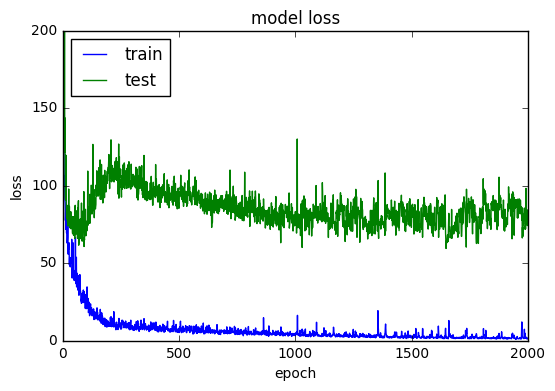

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
from keras.layers.advanced_activations import ELU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold,cross_val_score,train_test_split

# define base mode
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(transformedData.shape[1], input_dim=transformedData.shape[1], init='normal', activation='relu'))# activation=ELU(alpha=1.0)))
    model.add(Dropout(0.1))
    model.add(Dense(transformedData.shape[1]/2, init='normal', activation='relu'))# activation=ELU(alpha=1.0)))
    model.add(Dropout(0.1))
    model.add(Dense(transformedData.shape[1]/3, init='normal', activation='relu'))
    #model.add(Dense(10, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model


#steps = []
#steps.append(('scale',StandardScaler()))
#steps.append(('neural_net', KerasRegressor(build_fn=baseline_model, nb_epoch=300, batch_size=50, verbose=0)))

# fix random seed for reproducibility
#seed = 13
#np.random.seed(seed)
#kfold = KFold(transformedData.shape[0],n_folds=8, random_state=seed)
#results = cross_val_score(Pipeline(steps), transformedData, ages, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

import matplotlib.pyplot as plt
%matplotlib inline

scaler = Normalizer().fit(transformedData)
X = scaler.transform(transformedData)
X_train, X_test, y_train, y_test = train_test_split(X, ages, test_size=0.1)
#X_train, X_test, y_train, y_test = train_test_split(X, LabelBinarizer().fit_transform(sexes), test_size=0.1)

model = KerasRegressor(build_fn=baseline_model, nb_epoch=2000, batch_size=5, verbose=0)
#model = KerasClassifier(build_fn=baseline_model, nb_epoch=80000, batch_size=500, verbose=0)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=2000, verbose=1)
callbacks_list = [checkpoint]#, early_stop]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0, callbacks = callbacks_list)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim([0,200])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

84.183020603223369

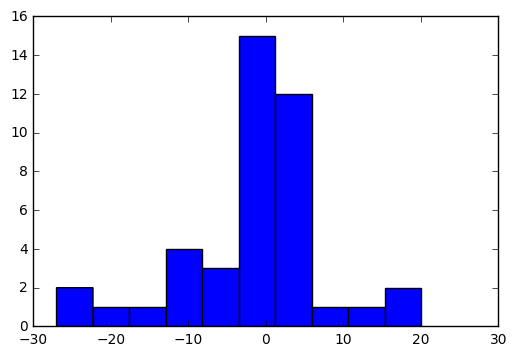

In [3]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error


#X_train, X_test, y_train, y_test = train_test_split(transformedData[sexes!='Male'], ages[sexes!='Male'], test_size=0.2)
#scaler = Normalizer().fit(transformedData)
#X = scaler.transform(transformedData)

# X_train, X_test, y_train, y_test = train_test_split(X, ages, test_size=0.2)
# X_test, y_test = X, ages
model = history.model

#model = KerasRegressor(build_fn=baseline_model, nb_epoch=800, batch_size=50, verbose=0)
#history = model.fit(X_train, y_train, validation_split=0.15, verbose=0)
errors = []
preds = []
for i in range(0,y_test.shape[0]):
    pred = model.predict(X_test[i].reshape(1,X_test.shape[1]))[0][0]
    preds.append(pred)
    errors.append(pred - float(y_test[i]))
    #print pred, y_test[i]
plt.hist(errors)
mean_squared_error(preds,y_test)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylim([0,200])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
y_test.dtype